In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata

In [1]:
def bsm_price(S, K, T, r, q, sigma, flag):
    """
    Calculates the Black-Scholes-Merton option price.

    Parameters:
    ----------
    S: Underlying asset price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free interest rate
    q: Continuous dividend yield
    sigma: Volatility
    flag: Option type ('c' for call, 'p' for put)

    Returns:
    -------
    float
        The calculated price of the option.
    """
    # Handle edge cases with zero/near-zero time to maturity or volatility by returning intrinsic value.
    if T <= 1e-6 or sigma <= 1e-6:
        return np.maximum(0, S * np.exp(-q * T) - K * np.exp(-r * T)) if flag == 'c' else np.maximum(0, K * np.exp(-r * T) - S * np.exp(-q * T))
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if flag == 'c':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def find_implied_vol(target_price, S, K, T, r, q, flag):
    """
    Calculates the implied volatility for an option.
    This is the volatility that makes the BSM price equal to the market price.

    Parameters:
    ----------
    price: Market price of the option
    S, K, T, r, q, flag: BSM model parameters

    Returns:
    -------
    float
        The implied volatility, or np.nan if not found.
    """
    # The objective is to find the root of: BSM_price(sigma) - target_price = 0
    objective = lambda sigma: bsm_price(S, K, T, r, q, sigma, flag) - target_price
    
    try:
        # Use a numerical solver (Brent's method) to find the root for sigma
        # within a reasonable search range (e.g., 0.01% to 500%).
        return brentq(objective, 1e-4, 5.0)
    except (ValueError, RuntimeError): # If no root is found, return NaN
        return np.nan

In [3]:
# Define the path to your CSV file.
# This assumes the CSV file is in the same directory as your script/notebook.
file_path = 'UnderlyingOptionsEODQuotes_2022-05-27.csv'
df = pd.read_csv(file_path)
    
print(f"The dataset contains {len(df)} rows.")

# Display the first 5 rows to confirm it's loaded correctly
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

The dataset contains 20032 rows.

First 5 rows of the DataFrame:
  underlying_symbol  quote_date root  expiration  strike option_type     open  \
0              ^SPX  2022-05-27  SPX  2022-06-17   200.0           C  3938.45   
1              ^SPX  2022-05-27  SPX  2022-06-17   200.0           P     0.00   
2              ^SPX  2022-05-27  SPX  2022-06-17   400.0           C     0.00   
3              ^SPX  2022-05-27  SPX  2022-06-17   400.0           P     0.00   
4              ^SPX  2022-05-27  SPX  2022-06-17   600.0           C     0.00   

      high      low    close  ...  underlying_ask_1545  bid_size_eod  bid_eod  \
0  3938.45  3938.45  3938.45  ...               4148.8            15   3954.8   
1     0.00     0.00     0.00  ...               4148.8             0      0.0   
2     0.00     0.00     0.00  ...               4148.8            15   3755.0   
3     0.00     0.00     0.00  ...               4148.8             0      0.0   
4     0.00     0.00     0.00  ...          

In [4]:
# --- Step 2: Filter and Clean the Data ---

# It's good practice to create a new DataFrame for the filtered data.
# This keeps the original 'df' unchanged if you need to go back.
df_filtered = df.copy()

# Filter 1: Keep only options with a positive end-of-day bid price.
# Options with a zero bid-ask price cannot be used to calculate a meaningful implied volatility.
df_filtered = df_filtered[df_filtered['bid_eod'] > 0]
df_filtered = df_filtered[df_filtered['ask_eod'] > 0]

# Filter 2: Keep only options with a certain level of trading volume (e.g., > 10).
# This helps to remove illiquid options where the price may be stale or unreliable.
df_filtered = df_filtered[df_filtered['trade_volume'] > 10]

# We also reset the index of the new dataframe for cleaner data handling later.
df_filtered = df_filtered.reset_index(drop=True)

print("Data filtering complete.")
print(f"Started with {len(df)} rows, now {len(df_filtered)} rows remain after filtering.")

# Display the first few rows of the filtered data to verify
print("\nFirst 5 rows of the filtered DataFrame:")
print(df_filtered.head())

Data filtering complete.
Started with 20032 rows, now 4352 rows remain after filtering.

First 5 rows of the filtered DataFrame:
  underlying_symbol  quote_date root  expiration  strike option_type     open  \
0              ^SPX  2022-05-27  SPX  2022-06-17  1000.0           C  3121.44   
1              ^SPX  2022-05-27  SPX  2022-06-17  2000.0           C  2122.06   
2              ^SPX  2022-05-27  SPX  2022-06-17  2100.0           P     0.07   
3              ^SPX  2022-05-27  SPX  2022-06-17  2150.0           P     0.12   
4              ^SPX  2022-05-27  SPX  2022-06-17  2425.0           P     0.17   

      high      low    close  ...  underlying_ask_1545  bid_size_eod  bid_eod  \
0  3121.44  3121.44  3121.44  ...               4148.8            15  3155.20   
1  2122.06  2122.06  2122.06  ...               4148.8            15  2156.10   
2     0.07     0.06     0.06  ...               4148.8             1     0.05   
3     0.12     0.10     0.10  ...               4148.8      

In [5]:
# --- Step 3: Feature Engineering (Calculate Necessary Columns) ---

# This block will add new columns to our filtered DataFrame that are required
# for the implied volatility calculation.

# Convert date columns from string 'object' type to datetime objects.
# This allows us to perform mathematical operations on dates.
df_filtered['quote_date'] = pd.to_datetime(df_filtered['quote_date'])
df_filtered['expiration'] = pd.to_datetime(df_filtered['expiration'])

# Convert the number of days to years, as this is the standard unit for 'T' in the Black-Scholes formula.
df_filtered['time_to_maturity'] = ((df_filtered['expiration'] - df_filtered['quote_date']).dt.days) / 365.0

# Calculate the mid-price (average of bid and ask) to use as the option's fair market price 'C'.
df_filtered['mid_price'] = (df_filtered['bid_eod'] + df_filtered['ask_eod']) / 2

# Create a final, clean DataFrame containing only the columns we will need moving forward.
# This makes the dataset easier to work with.
clean_df = df_filtered[[
    'time_to_maturity',
    'strike',
    'option_type',
    'mid_price',
    'underlying_bid_eod',
    'underlying_ask_eod'
]].copy()

# Remove options that are very close to expiration (e.g., less than 2 days).
# This is another common cleaning step to avoid division-by-zero errors or other numerical instabilities.
clean_df = clean_df[clean_df['time_to_maturity'] > (2 / 365.0)]


print("New columns calculated successfully.")
print("\nDataFrame with new 'time_to_maturity' and 'mid_price' columns (first 5 rows):")
print(clean_df.head())

New columns calculated successfully.

DataFrame with new 'time_to_maturity' and 'mid_price' columns (first 5 rows):
   time_to_maturity  strike option_type  mid_price  underlying_bid_eod  \
0          0.057534  1000.0           C   3158.450             4157.61   
1          0.057534  2000.0           C   2159.250             4157.61   
2          0.057534  2100.0           P      0.100             4157.61   
3          0.057534  2150.0           P      0.125             4157.61   
4          0.057534  2425.0           P      0.200             4157.61   

   underlying_ask_eod  
0             4158.75  
1             4158.75  
2             4158.75  
3             4158.75  
4             4158.75  


In [8]:
# Calculate the spot price as the midpoint of the underlying's end-of-day bid and ask prices.
spot_price = (clean_df['underlying_bid_eod'].iloc[0] + clean_df['underlying_ask_eod'].iloc[0]) / 2

risk_free_rate = 0.010
dividend_yield = 0.016

print(f"Using Spot Price (S): {spot_price:.2f}")
print(f"Using Risk-Free Rate (r): {risk_free_rate}")
print(f"Using Dividend Yield (q): {dividend_yield}")


# Calculate Implied Volatility for each option

# First, filter out any options with a non-positive mid-price, as they are invalid.
clean_df = clean_df[clean_df['mid_price'] > 0]


# --- Arbitrage Filter ---
# Calculate the theoretical lower bound (present value of intrinsic value) for each option.
# This prevents calculations on options priced below their minimum possible theoretical value.
intrinsic_value = np.where(
        # For call options: max(0, S*e^(-qT) - K*e^(-rT))
        clean_df['option_type'] == 'C',
        np.maximum(0, spot_price * np.exp(-dividend_yield * clean_df['time_to_maturity']) - clean_df['strike'] * np.exp(-risk_free_rate * clean_df['time_to_maturity'])),
        # For put options: max(0, K*e^(-rT) - S*e^(-qT))
        np.maximum(0, clean_df['strike'] * np.exp(-risk_free_rate * clean_df['time_to_maturity']) - spot_price * np.exp(-dividend_yield * clean_df['time_to_maturity']))
    )

# Keep only the options where the market price is greater than or equal to the calculated lower bound.
clean_df = clean_df[clean_df['mid_price'] >= intrinsic_value]

# Apply the implied volatility function to each row of the cleaned dataframe.
clean_df['implied_vol'] = clean_df.apply(
    lambda row: find_implied_vol(
        target_price=row['mid_price'], 
        S=spot_price, 
        K=row['strike'], 
        T=row['time_to_maturity'],
        r=risk_free_rate, 
        q=dividend_yield, 
        flag=row['option_type'].lower() # Ensure flag is 'c' or 'p'
    ),
    axis=1) # Apply function row-wise.

# Create the final dataframe by dropping any rows where implied volatility could not be calculated (resulted in NaN).
final_surface_df = clean_df.dropna(subset=['implied_vol'])

# Print a summary message indicating completion and the number of valid data points.
print(f"Data processing complete. Filtered out arbitrage violations. Using {len(final_surface_df)} points to build the surface.")

Using Spot Price (S): 4158.18
Using Risk-Free Rate (r): 0.01
Using Dividend Yield (q): 0.016
Data processing complete. Filtered out arbitrage violations. Using 4197 points to build the surface.


The most common maturity in the dataset is 21 days away. Plotting smile for this maturity.


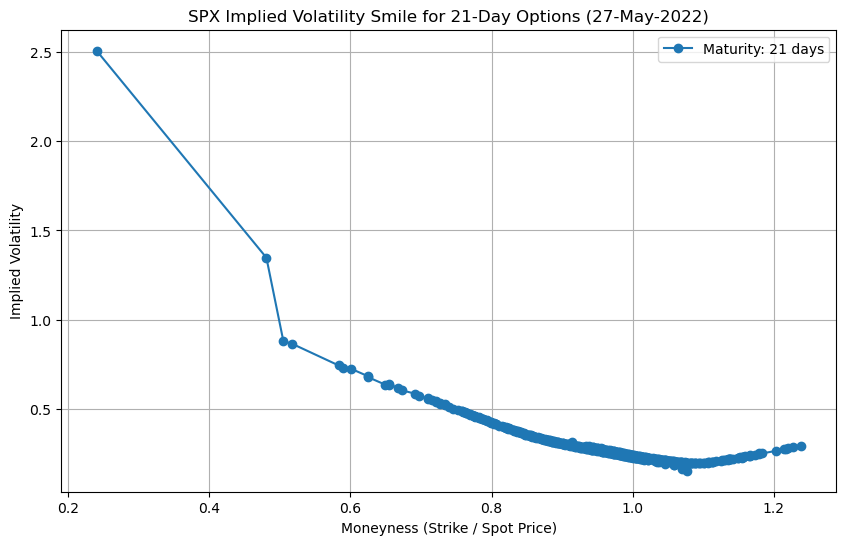

In [9]:
# --- Step 5: Visualize the Volatility Smile ---



# First, let's find the maturity that has the most options available in our dataset.
# This will likely be a standard, liquid expiration date.
# We need to convert the expiration dates back from time_to_maturity for this.
# Let's find the most common 'time_to_maturity' value.
most_common_maturity = final_surface_df['time_to_maturity'].mode()[0]
print(f"The most common maturity in the dataset is {most_common_maturity*365:.0f} days away. Plotting smile for this maturity.")

# Filter the DataFrame to get only the options for this specific maturity.
smile_df = final_surface_df[final_surface_df['time_to_maturity'] == most_common_maturity].copy()

# For a better plot, it's common to use 'moneyness' (Strike / Spot) on the x-axis.
smile_df['moneyness'] = smile_df['strike'] / spot_price

# Sort the values by strike price to ensure the line plot connects points correctly.
smile_df = smile_df.sort_values(by='strike')


# --- Plotting ---

# Create a plot figure and axes
plt.figure(figsize=(10, 6))

# Plot the implied volatility against moneyness
# We use a line plot to see the 'smile' shape and scatter to see the individual data points
plt.plot(smile_df['moneyness'], smile_df['implied_vol'], marker='o', linestyle='-', label=f'Maturity: {most_common_maturity*365:.0f} days')
# plt.scatter(smile_df['moneyness'], smile_df['implied_vol'], label='Data Points')


# Add titles and labels for clarity
plt.title(f'SPX Implied Volatility Smile for {most_common_maturity*365:.0f}-Day Options (27-May-2022)')
plt.xlabel('Moneyness (Strike / Spot Price)')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

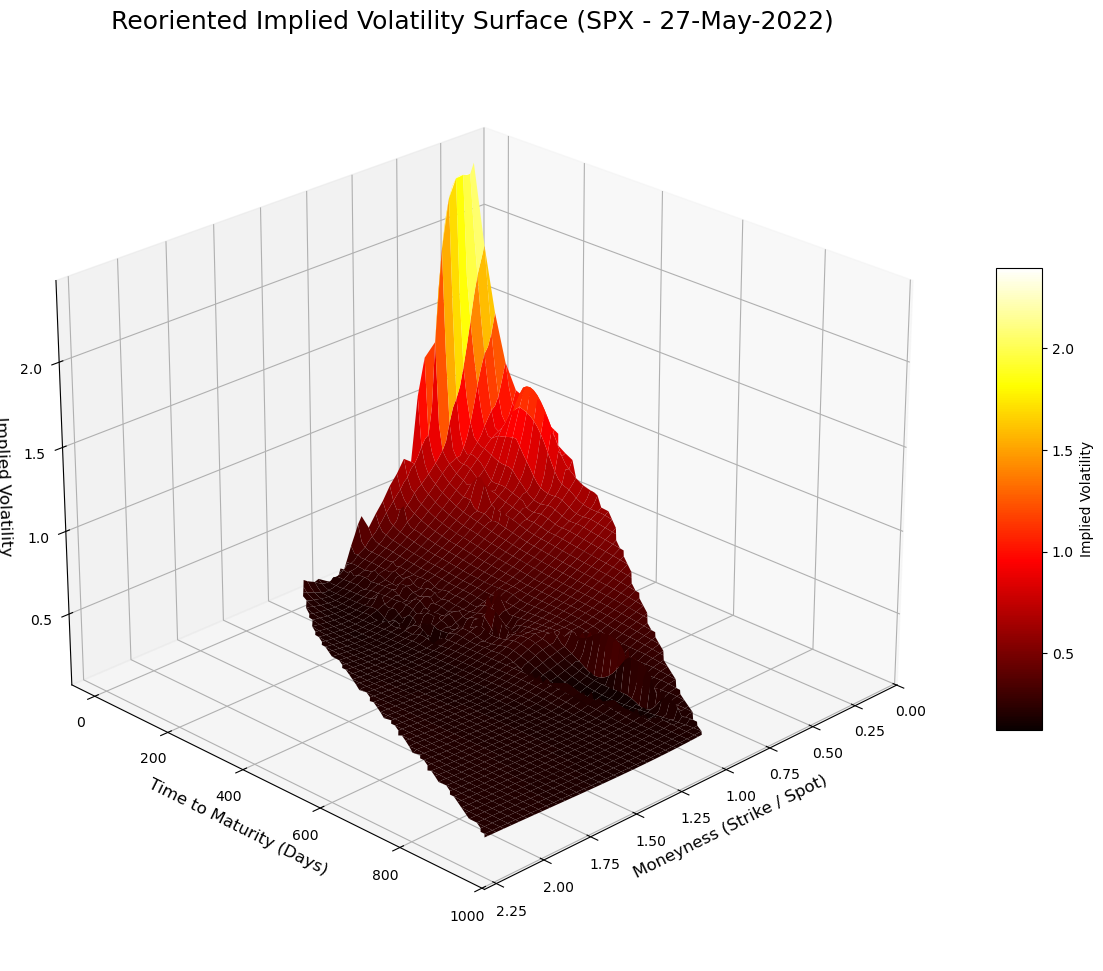


SUCCESS: 3D surface plot generated and saved as 'smooth_surface_3d_reoriented.png' (300 DPI)


In [10]:
# --- Part C: Rotated and Re-colored 3D Surface Plot ---
    
# Prepare data for interpolation with swapped axes.
# X will now be Moneyness, Y will be Time to Maturity, and Z is Implied Vol.
x_data = (final_surface_df['strike'] / spot_price).values
y_data = final_surface_df['time_to_maturity'].values
z_data = final_surface_df['implied_vol'].values
    
# Create a regular grid of points to interpolate the scattered data onto.
x_grid_new = np.linspace(min(x_data), max(x_data), 100)
y_grid_new = np.linspace(min(y_data), max(y_data), 100)
X_grid_new, Y_grid_new = np.meshgrid(x_grid_new, y_grid_new)
    
# Interpolate the Z values (implied vol) onto the new grid using cubic interpolation for a smooth surface.
Z_grid_new = griddata((x_data, y_data), z_data, (X_grid_new, Y_grid_new), method='cubic')
    
# --- Plotting ---

# Create the figure and a 3D subplot.
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
    
# Set the background color of the plot and the surrounding figure to white for a clean look.
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Plot the smooth surface using the interpolated grid data.
# The colormap 'hot' is used, and Y is multiplied by 365 to show days.
surface = ax.plot_surface(X_grid_new, Y_grid_new * 365, Z_grid_new, cmap='hot', edgecolor='none')
    
# Set the main title and axis labels for the plot.
ax.set_title('Reoriented Implied Volatility Surface (SPX - 27-May-2022)', fontsize=18)
ax.set_xlabel('Moneyness (Strike / Spot)', fontsize=12)
ax.set_ylabel('Time to Maturity (Days)', fontsize=12)
ax.set_zlabel('Implied Volatility', fontsize=12)
    
# Adjust the viewing angle (elevation and azimuth) for a better perspective.
ax.view_init(elev=25, azim=45)
    
# Add a color bar to serve as a legend for the implied volatility values.
fig.colorbar(surface, shrink=0.5, aspect=10, label='Implied Volatility')
    
# Save the generated figure to a file and close the plot to free memory.
plt.savefig('smooth_surface_3d_reoriented.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Close to free memory
plt.close()

print("\nSUCCESS: 3D surface plot generated and saved as 'smooth_surface_3d_reoriented.png' (300 DPI)")

## **Comparison Between The Given Implied Volatility and The Calculated Implied Volatility**

Our custom calculation resulted in 4197 valid implied volatilities.
Provider's data loaded. Contains 20032 rows.
Successfully merged the two datasets. Comparing 5636 common options.

--- Numerical Comparison of Implied Volatilities ---
Statistics for the difference (Custom IV - Provider IV):
count    5636.000000
mean        0.004879
std         0.057845
min        -0.078046
25%        -0.003046
50%         0.001027
75%         0.006791
max         2.506891
Name: difference, dtype: float64


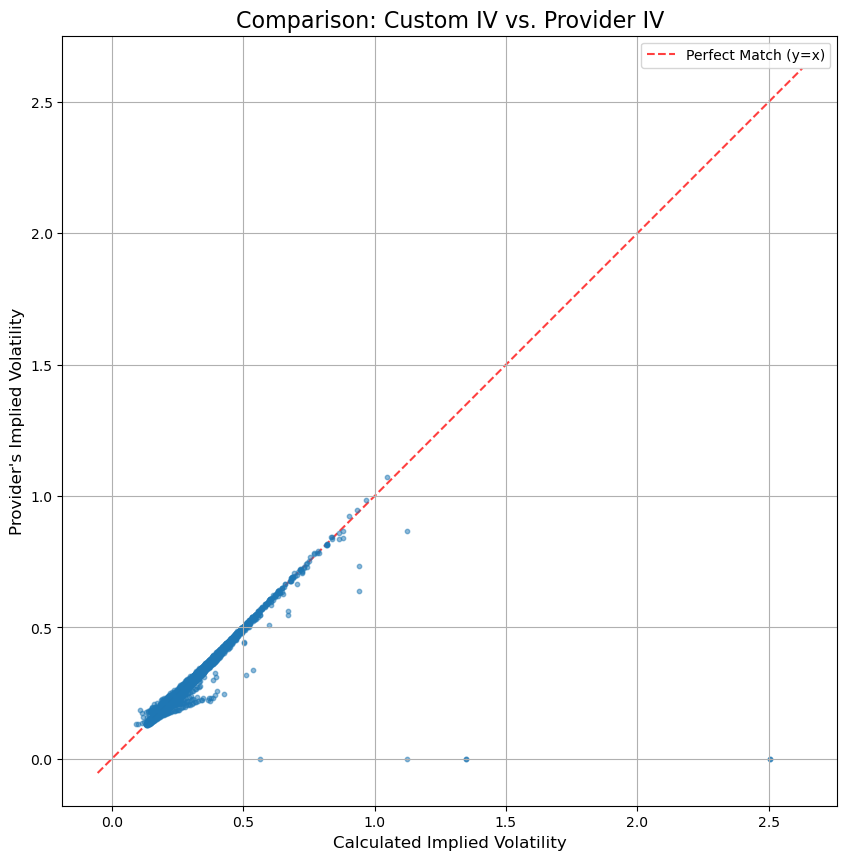


SUCCESS: Comparison plot displayed and saved as 'iv_comparison_300dpi.png'


In [12]:
quotes_file = 'UnderlyingOptionsEODQuotes_2022-05-27.csv'
df_quotes = pd.read_csv(quotes_file)
    

df_filtered = df_quotes[(df_quotes['bid_eod'] > 0) & (df_quotes['ask_eod'] > 0) & (df_quotes['trade_volume'] > 10)].copy()
df_filtered['quote_date'] = pd.to_datetime(df_filtered['quote_date'])
df_filtered['expiration'] = pd.to_datetime(df_filtered['expiration'])
df_filtered['time_to_maturity'] = ((df_filtered['expiration'] - df_filtered['quote_date']).dt.days) / 365.0
df_filtered['mid_price'] = (df_filtered['bid_eod'] + df_filtered['ask_eod']) / 2
    
our_df = df_filtered[['expiration', 'strike', 'option_type', 'time_to_maturity', 'mid_price', 'underlying_bid_eod', 'underlying_ask_eod']].copy()
our_df = our_df[our_df['time_to_maturity'] > (2 / 365.0)]
    
spot_price = (our_df['underlying_bid_eod'].iloc[0] + our_df['underlying_ask_eod'].iloc[0]) / 2
risk_free_rate = 0.010
dividend_yield = 0.016
    
intrinsic_value = np.where(
    our_df['option_type'] == 'C',
    np.maximum(0, spot_price * np.exp(-dividend_yield * our_df['time_to_maturity']) - our_df['strike'] * np.exp(-risk_free_rate * our_df['time_to_maturity'])),
    np.maximum(0, our_df['strike'] * np.exp(-risk_free_rate * our_df['time_to_maturity']) - spot_price * np.exp(-dividend_yield * our_df['time_to_maturity']))
)
our_df = our_df[our_df['mid_price'] >= intrinsic_value]
    
# Calculate our custom implied volatility
our_df['iv_custom'] = our_df.apply(
    lambda row: find_implied_vol(
        target_price=row['mid_price'], S=spot_price, K=row['strike'], T=row['time_to_maturity'],
        r=risk_free_rate, q=dividend_yield, flag=row['option_type'].lower()
    ),
    axis=1
)
our_df = our_df.dropna(subset=['iv_custom'])
print(f"Our custom calculation resulted in {len(our_df)} valid implied volatilities.")

    # --- Part C: Load Provider's Data ---
    
calcs_file = 'UnderlyingOptionsEODCalcs_2022-05-27.csv'
df_provider = pd.read_csv(calcs_file)
    
    # Select only the necessary columns from the provider's data
provider_df = df_provider[['expiration', 'strike', 'option_type', 'implied_volatility_1545']].copy()
provider_df = provider_df.rename(columns={'implied_volatility_1545': 'iv_provider'})
    
    # Convert expiration to datetime to ensure a correct merge
provider_df['expiration'] = pd.to_datetime(provider_df['expiration'])
print(f"Provider's data loaded. Contains {len(provider_df)} rows.")

    # --- Part D: Merge and Compare ---
    
    # Merge the two dataframes on the unique option identifiers
comparison_df = pd.merge(
    our_df[['expiration', 'strike', 'option_type', 'iv_custom']],
    provider_df,
    on=['expiration', 'strike', 'option_type']
)
print(f"Successfully merged the two datasets. Comparing {len(comparison_df)} common options.")
    
    # Calculate the difference
comparison_df['difference'] = comparison_df['iv_custom'] - comparison_df['iv_provider']

# 1. Numerical Comparison
print("\n--- Numerical Comparison of Implied Volatilities ---")
print("Statistics for the difference (Custom IV - Provider IV):")
print(comparison_df['difference'].describe())
    
# 2. Visual Comparison
# Create the figure for the plot
plt.figure(figsize=(10, 10))
plt.scatter(comparison_df['iv_custom'], comparison_df['iv_provider'], alpha=0.5, s=10)
    
# Add the y=x line for perfect agreement
lims = [
    np.min([plt.xlim(), plt.ylim()]),
    np.max([plt.xlim(), plt.ylim()]),
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Match (y=x)')
    
# Set titles and labels
plt.title('Comparison: Custom IV vs. Provider IV', fontsize=16)
#plt.title(fr'Comparison: Custom IV vs. Provider IV$', fontsize=16)
plt.xlabel('Calculated Implied Volatility', fontsize=12)
plt.ylabel("Provider's Implied Volatility", fontsize=12)
plt.grid(True)
plt.legend()
plt.axis('equal') # Ensure the plot is square for a proper 45-degree line

# --- YENİ DEĞİŞİKLİKLER BURADA ---

# 1. Save the figure with high resolution (300 DPI) and tight layout
#    Dosya adını da kalitesini yansıtacak şekilde değiştirmek iyi bir pratiktir.
plt.savefig('iv_comparison_600dpi.png', dpi=600, bbox_inches='tight')

# 2. Display the plot on the screen
plt.show()

# 3. Close the plot object to free up memory
plt.close()
    
# Update the confirmation message
print("\nSUCCESS: Comparison plot displayed and saved as 'iv_comparison_300dpi.png'")
